In [1]:
from dask.distributed import Client, progress
client = Client(n_workers=2, threads_per_worker=2, memory_limit='1GB')
client

Client Scheduler: tcp://127.0.0.1:39577 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 2.00 GB


In [2]:
import pandas as pd
import numpy as np
from scipy.stats import bernoulli 
from typing import List, Callable, Dict, Tuple, Iterable
from fancyimpute import SimpleFill, KNN
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
#from sklearn.impute import SimpleImputer
#from sklearn.model_selection import cross_val_score as cvs
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
import seaborn as sns
#plt.style.use('dark_background')
from category_encoders import BinaryEncoder
from tqdm import tqdm
import dask.dataframe as dd
import pickle

DataFrame = pd.core.frame.DataFrame
Series = pd.core.series.Series
Array = np.ndarray
Imputer = Callable[[DataFrame], DataFrame]
nan = np.nan

df = dd.read_csv('data.csv').drop(['name'], axis=1)
X_ = df.drop('status_group', axis=1)
y = df.status_group

be = BinaryEncoder()
FEATS = 20

pca = PCA(n_components = FEATS)

vals= pca.fit_transform(StandardScaler().fit_transform(be.fit_transform(X_.compute())))

X = pd.DataFrame(vals, columns=[f"pc{k+1}" for k in range(FEATS)], index=y.index).assign(y=y)

# #X_15percent = demon(X, 0.15)

# X_15percent.isna().sum(), X.isna().sum()
X.head()

Using TensorFlow backend.


,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,...,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20,y
0,-3.097843,-1.462656,-1.468433,1.344540,2.470875,-0.231420,-0.288755,-1.856303,0.125985,0.461903,...,-0.388310,0.671434,0.885379,-1.353271,1.244451,0.416598,0.577016,-0.496483,0.206665,1
1,1.383141,2.902360,-1.704113,-2.272890,-0.123384,-2.115764,-1.693482,-0.545425,-0.890894,0.495923,...,-0.522679,2.315934,-0.256382,1.033956,1.286728,1.166181,-1.226949,1.808140,0.350276,1
2,-2.900721,-0.609838,-1.166242,0.349704,1.958080,-0.138313,-2.728554,-2.931573,-0.352108,0.792521,...,-1.400305,1.552558,0.700345,-0.687829,0.863799,0.184842,0.241951,-1.328060,-0.376989,1
3,1.633112,-3.351487,-2.635620,0.029272,-0.660171,1.912512,-0.784475,-0.235328,-2.262109,-3.417716,...,0.515717,1.010999,0.606961,-0.518352,-0.041442,0.174319,-0.750950,0.621988,-0.697795,-1
4,3.907189,0.247174,3.948471,3.149479,-1.715389,-0.480070,0.574735,-1.135638,-3.650010,-0.527869,...,-0.117147,0.717229,1.832905,-1.546372,0.346698,-1.134791,-1.103692,0.386921,0.166135,-1


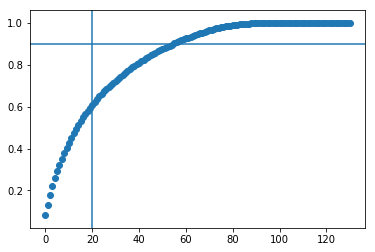

In [3]:
vals_ = BinaryEncoder().fit_transform(X_.compute())
from sklearn.decomposition import TruncatedSVD

pca = PCA(n_components=vals_.shape[1])
pca.fit(StandardScaler().fit_transform(vals_))
plt.scatter(x=range(vals_.shape[1]), y=pca.explained_variance_ratio_.cumsum())
plt.axhline(0.9);
plt.axvline(FEATS)

1. refactor so X,y split happens after demon
2. 

In [7]:

def mcar_goblin(dat: DataFrame, ratio: float) -> DataFrame: 
    ''' Simulate MCAR with bernoulli '''
    def ident_or_nan(x: float) -> float:
        ''' if heads, replace value with nan. if tails, identity '''
        coin = bernoulli(ratio)
        if coin.rvs()==1: 
            return nan
        else: 
            return x
    
    return dat.assign(**{feat: [ident_or_nan(x) 
                                for x in dat[feat].values] 
                         for feat in dat.columns if feat!='y'})

def coefs(imputer: Imputer, X: DataFrame, y: Series) -> Tuple[str, Array]: 
    ''' '''
    lm = LogisticRegression(multi_class='auto', solver='lbfgs', max_iter=10000)
    
    lm.fit(imputer(X), y)
    return (imputer.__name__, 
            np.array([sum(col**2)**0.5 for col in lm.coef_.T]) # column-norms, feature importances 
           )

def idem(dat: DataFrame) -> DataFrame: 
    '''no missin'''
    return dat
    
def fill_mean(dat: DataFrame) -> DataFrame: 
    return SimpleFill(fill_method='mean').fit_transform(dat)

def fill_noise(dat: DataFrame) -> DataFrame: 
    return SimpleFill(fill_method='random').fit_transform(dat)

def iterative(dat: DataFrame) -> DataFrame: 
    return IterativeImputer().fit_transform(dat)

def knn(dat: DataFrame) -> DataFrame: 
    return KNN(verbose=False).fit_transform(dat)

def drop(dat: DataFrame) -> DataFrame: 
    return dat.dropna(axis=0)

imputers: List[Imputer] = [fill_mean, fill_noise, iterative, knn]#, drop]

def experiment(imputers: List[Imputer], 
               X_: DataFrame, 
               y: Series, 
               ratio: float, 
               passes: int) -> Iterable[Tuple[Array, Array]]: 
    
    control = coefs(idem, X_, y)
    for k in tqdm(range(passes), desc=f"goblin {ratio*100}% - {passes} passes"): 
        X = mcar_goblin(X_, ratio)
        for imputer in imputers: 
            yield control, coefs(imputer, X, y) 
        
def result(xprmnt: Iterable[Tuple[Tuple[str, Array], 
                                  Tuple[str, Array]]]) -> DataFrame: 
    deltas = [(outcome[1][0], outcome[0][1] - outcome[1][1])
              for outcome in xprmnt]
    
    return (DataFrame([[delt[0]] + list(delt[1]) for delt in deltas])
            .rename(columns={**{0: 'imputer'}}))#, **{k: f"coef_norm_{k}" for k in range(1, FEATS+1)}}))

In [58]:
# type(coefs(fill_mean, X, y)[1])
TRIALS = 4
result_df_10percent = result(experiment(imputers, X, y, 0.1, TRIALS)).drop('imputer', axis=1).values.reshape(-1, 1)
result_df_30percent = result(experiment(imputers, X, y, 0.3, TRIALS)).drop('imputer', axis=1).values.reshape(-1, 1)

with open("results_tuple_3010.pickle", "wb") as serialize_results: 
    pickle.dump((result_df_10percent, result_df_30percent), serialize_results)

# result_df = DataFrame().assign(twenty = result_df_20percent.drop('imputer', axis=1).T.mean(), 
#                                fourty = result_df_40percent.drop('imputer', axis=1).T.mean())

#assert result_df_20percent.drop('imputer', axis=1).values.reshape(-1, 1).shape[0] == result_df_20percent.drop('imputer', axis=1).shape[0] * result_df_20percent.drop('imputer', axis=1).shape[1]

result_df = DataFrame().assign(ten_percent_goblin = result_df_10percent.T[0], thirty_percent_goblin = result_df_30percent.T[0])

#result_df_40percent.T[0]

result_df.head()

goblin 30.0% - 4 passes: 100%|██████████| 4/4 [02:11<00:00, 32.92s/it]


,ten_percent_goblin,thirty_percent_goblin
0,0.009418,0.001256
1,0.007439,-0.008896
2,0.011740,0.000849
3,0.008939,0.028767
4,-0.001485,-0.004076


AttributeError: 'AxesSubplot' object has no attribute 'savefig'

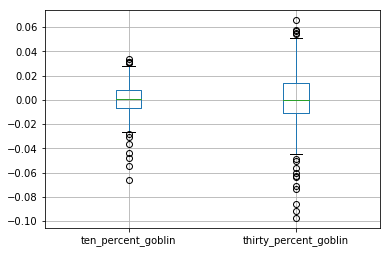

In [66]:
result_df[abs(result_df) < 0.1].boxplot()#.savefig('result_boxplot.png')

In [61]:
#result_df.drop('imputer', axis=1).T.sum()

In [29]:
result_df_20percent.drop('imputer', axis=1).values.reshape(-1, 1).shape

(336, 1)

# MAR modeling

In [50]:

#X_30percent = demon(X, 0.30)

X.head()

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,y
0,35993.919633,-14.341891,472.707283,284.041525,1.359304,-7.520371,-2.977720,0.902390,1.604534,2.182541,1
1,24570.781502,-202.109411,-430.016138,-250.244303,1.432325,-2.830826,0.615532,0.545489,2.262331,-0.264660,1
2,-20489.058358,189.552166,458.464012,328.190463,-0.184663,-8.168553,-2.584106,2.350798,2.760817,2.071968,1
3,29568.830210,-332.620346,728.267152,111.001718,0.523891,-4.123882,-0.113707,-3.627478,0.045240,-1.043646,-1
4,-32462.170964,-329.538300,721.842341,117.308182,-2.236597,-0.054609,6.958001,0.709138,0.077878,-0.809528,-1


In [58]:
from numpy.random import choice, randint

cols = X.columns


randint(len(X.columns) - 1)

8

In [45]:
type(drop(X))

pandas.core.frame.DataFrame